In [1]:
from node2vec import Node2Vec
import networkx as nx
#import igraph
import matplotlib as plt
import csv
import pandas as pd
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
from annoy import AnnoyIndex
from sklearn.manifold import TSNE
import seaborn as sns 
import umap.umap_ as umap
from sklearn import preprocessing
from sklearn.decomposition import PCA
import subprocess
import os

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


# DEFAULT PARAMETER SETTING

In [2]:
sc.settings.verbosity = 2
np.set_printoptions(precision=2)
reducer = umap.UMAP(random_state=42)
G_normalized = nx.Graph()

# READ 10X DATA

In [3]:
adata = sc.read_10x_mtx(
'G:/Thesis/Dropclust/dataset/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
cache=True) 

... reading from cache file cache\G-Thesis-Dropclust-dataset-filtered_gene_bc_matrices-hg19-matrix.h5ad


# FILTER CELL AND GENES

In [ ]:
#scanpy package is used for the preprocessing steps where filtering of cells is done by 
#setting the min count to 3 followed by filtering of the genes with min cell count =3.
#This is followed by extraction of the top 1000 variable genes

In [5]:
t=sc.pp.filter_cells(adata,min_counts=3)
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=1000)
variable_genes=adata.var['highly_variable']
variable_gene_list = []
for ind in variable_genes.index:
    if variable_genes[ind]==False:
        variable_gene_list.append(ind)

# NORMALIZATION

In [ ]:
#Total  Normalixation from the scanpy package is performed with target sum equals to 1, where after normalization the
#total sum of normalized values of all cells is equal to 1

In [8]:
sc.pp.normalize_total(adata, target_sum=1, inplace=True)
data_df = adata.to_df()
read_data_df = adata.to_df()
column_names = data_df.columns

# LOUVAIN CLUSTERING

In [ ]:
#Scanpy package is used for louvain clustering 
#At the first step nearest neighbor with neighbor count =25 have been found out followed by 
#louvaiun clustering on the initial dataset. This will give the cluster count and cells belonging to their
#respective clusters

In [9]:
sc.pp.neighbors(adata,n_neighbors=25)
sc.tl.louvain(adata)
p=np.array(adata.uns['neighbors']['distances'].todense())
neighbor_df = pd.DataFrame(p,columns=list(read_data_df.index),index=list(read_data_df.index))
louvain_cluster_df=sc.get.obs_df(adata,keys=["louvain"])
n_cluster=louvain_cluster_df['louvain'].nunique()
size_per_cluster = louvain_cluster_df['louvain'].value_counts()

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:02)
    finished (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01)


# SUBSAMPLING

In [ ]:
#In order to maintain the proportion of the samples from smaller clusters, an exponential decay function
#is used to determine the proportions of the transcriptomes to be sampled from each cluster.Here pl is the 
#lower bound of the proportion and pu is the upper bound of the proportion, K is the scaling factor.
#Random samples are extracted per clusters based on the proportions calcluated.

In [10]:
pl=0.05
pu=0.9
k=500
prob_per_cluster=[]
for i in range(0,n_cluster):
    prob_per_cluster.append(pl-np.exp(-(size_per_cluster[i]/k))*(pl-pu))
sample_per_cluster=[]
for i in range(0,n_cluster):
    sample_per_cluster.append(int(prob_per_cluster[i]*size_per_cluster[i]))
sampled_df = pd.DataFrame(columns=data_df.columns)
left_out_cells=[]
for i in range(0,n_cluster):
    cells=list(louvain_cluster_df.loc[louvain_cluster_df['louvain'] == str(i)].index)
    sample = np.random.choice(cells,sample_per_cluster[i],replace=False)
    remainder = list(set(cells)-set(sample))
    left_out_cells=left_out_cells+remainder
    for smp in sample:
        sampled_df=sampled_df.append(data_df.loc[smp])
data_df=sampled_df
column_names = data_df.columns

# TOP PCA GENES

In [ ]:
#In this block top 300 pca genes are selected

In [11]:
pca = PCA(n_components=500, svd_solver='full')
pca.fit(data_df)
rotation_mat = np.transpose(abs(pca.components_)) 
rotation_matrix_df = pd.DataFrame(rotation_mat,index=column_names)
gene_max = rotation_matrix_df.max(axis=1)
gene_max=gene_max.sort_values(ascending=False)
pca_genes = list(gene_max[:300].index)
pca_genes_df = data_df[pca_genes]
cell_names = list(pca_genes_df.index.values)
column = list(pca_genes_df.columns)
pca_genes_df.to_csv('pca_genes_df.csv')

# VISUALISE SELECTED GENES 

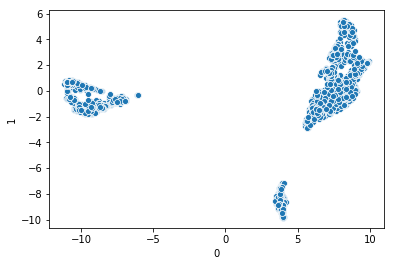

In [23]:
df=reducer.fit_transform(pca_genes_df)
df=pd.DataFrame(df)
ax = sns.scatterplot(x=0, y=1, data=df)

# TOP VARIABLE GENES INSTEAD OF PCA GENES

In [18]:
pca_genes_df = data_df
pca_genes_df=pca_genes_df.drop(variable_gene_list,axis=1)
cell_names = list(pca_genes_df.index.values)
column = list(pca_genes_df.columns)

# CELL CELL GRAPH BY ANNOY

In [ ]:
#Spotify annoy package is used to create the cell-cell graph in order to get the nearesr neighbor 
#of every nodes(cells)

In [12]:
f = len(pca_genes_df.columns)
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i in range(len(pca_genes_df.index)):
    v  = pca_genes_df.iloc[i]
    t.add_item(i, v)

t.build(30) # 10 trees
#t.save('test.ann')

True

In [13]:
cell_cell_df = pd.DataFrame(index=[0,1,2,3,4,5])
for i in range(len(pca_genes_df.index)):
               knn_values = list(t.get_nns_by_item(i,7,include_distances=True))
               #cells = knn_values[0]
               cell_cell_df["item."+str(i)]=knn_values[0][1:]
               cell_cell_df["distance."+str(i)] = knn_values[1][1:]
cell_graph_column = list(cell_cell_df.columns)

# CELL-GENE CONNECTION

In [ ]:
#For every cell top 20 most expressed genes are connected thus forming the cell-gene connections

In [14]:
cell_gene_edge_list = []
for col in column:
    n_cells = pca_genes_df.nlargest(20,col)[col].index.values
    
    for cell in n_cells:
        temp=[]
        temp.append(col)
        #temp.append(cell_names.index(cell)+1)
        temp.append(cell)
        temp.append(float(1))
        cell_gene_edge_list.append(tuple(temp))
        i=5
        while(i>=1):
            distance="distance."+str(cell_names.index(cell))
            if cell_cell_df.iloc[i][distance]!=999:
                cell_cell_df.set_value(i,distance,999)
                break
            else:
                i=i-1
G_normalized.add_weighted_edges_from(cell_gene_edge_list)

C:\Users\Swagatam\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


# CELL -CELL WITHOUT DROPPING CELL CONNECTIONS

In [ ]:
#For every cell nearest 7 nodes(cells) are connected to form the cell-cell connections

In [15]:
cell_cell_edge_list=[]
c=0
g=0
for col in cell_graph_column:
    if "distance" in col or "Unnamed" in col:
        continue
    else:
        if col=="item":
            distance="distance"
        else:
            distance="distance."+str(col[5:])
        for i in range(1,6):
            temp_edge=[]
            #if cell_cell_df.iloc[i][distance]!=999:
            temp = list(cell_cell_df["distance."+str(int(cell_cell_df.iloc[i][col]))])
                #if col[5:] not in temp or (col[5:] in temp and col[5:]!=999):
            #temp_edge.append(str(int(col[5:])+1))
            #temp_edge.append(str(int(cell_cell_df.iloc[i][col])))
            temp_edge.append(pca_genes_df.index[int(col[5:])])
            temp_edge.append(pca_genes_df.index[int(cell_cell_df.iloc[i][col])])
            temp_edge.append(float(1))
                    #if len(temp_edge) !=0:
            cell_cell_edge_list.append(tuple(temp_edge))
            c=c+1
                        #print(temp_edge)
                #else:
                #    g=g+1
G_normalized.add_weighted_edges_from(cell_cell_edge_list)
print(c,g)

6765 0


# CONNECTION CHECK

In [ ]:
cc=0
cg=0
gg=0
for (node1,node2) in G_normalized.edges:
    node1= str(node1)
    node2=str(node2)
    if node1.isnumeric() and node2.isnumeric():
        cc=cc+1
    if (node1.isnumeric() and not node2.isnumeric()) or (not node1.isnumeric() and node2.isnumeric()):
        cg = cg+1
    if not node1.isnumeric() and not node2.isnumeric():
        gg=gg+1
print(cc,cg,gg)

# WRITE GRAPH

In [ ]:
#The graph created above is saved in the form of gexf file and the nearest neighbor nodes from each nodes 
# is also saved in the form of csv format.

In [16]:
nx.write_gexf(G_normalized, "C:/Users/Swagatam/IdeaProjects/openOrd/graphs/graph_normalized_own_cc.gexf")
neighbor_df=neighbor_df.drop(list(sampled_df.index),axis=0)
neighbor_df=neighbor_df.drop(left_out_cells,axis=1)
neighbor_df.to_csv('neighbor.csv')

# OPENORD LAYOUT

In [ ]:
#in this block the java code is run in the form of jar file which embeds the openord layout
#over the graph obtained above.

In [ ]:
subprocess.call(['java', '-jar', 'openOrd.jar',out_path+'graph_normalized_own_cc.gexf',out_path+'output_normalized_own_cc.csv'])